In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, sum_labels
import multiprocessing
import itertools
from functools import partial
import seaborn as sn

In [2]:
edge_to_bin = lambda edges: 0.5*(edges[1:]+edges[:-1])

In [3]:
# Define a domain
L_m = int(1e6)

In [4]:
# Exponential function to draw clouds from
L1_m = 100.0

In [5]:
exp_size_distribution = lambda size: np.random.exponential(scale=L1_m, size = size)

uniform_x_distribution = lambda size: np.random.randint(0, L_m, size = size)
norm_x_distribution = lambda size, scale: np.random.normal(loc=0.5*L_m, scale=L_m*scale, size = size)

norm_x_distribution(1, 0.1)

array([609785.5651995])

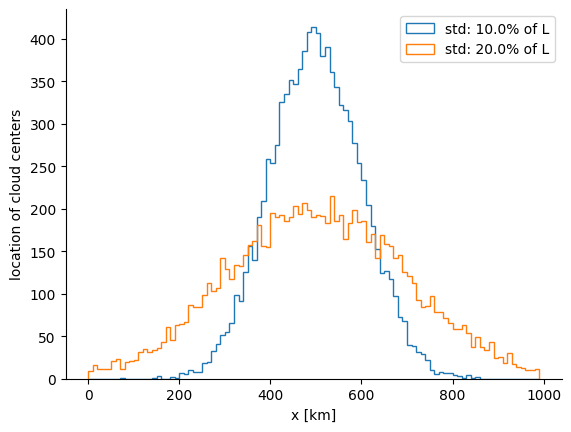

In [17]:
for scale in [0.1, 0.2]:
    plt.hist(partial(norm_x_distribution, scale = scale)(int(1e4))/1e3, 
             bins = np.arange(0, L_m/1e3, 1e1), 
             histtype="step", 
             label=f"std: {scale*100}% of L")

plt.xlabel("x [km]")
plt.ylabel("location of cloud centers")
plt.legend()
sn.despine();

In [7]:
def cloud_model(L_m, p_cov, size_distribution, x_distribution, seed):
    
    np.random.seed(seed=seed)
    
    p = 0.0

    x_m = np.zeros(L_m)

    cloud_lengths_m = []
    
    size = int(1e4)
    cloud_lengths_m = size_distribution(size = size)
    
    xs_m = x_distribution(size = size)

    i = 0
    while p < p_cov:

        x_cloud = int(xs_m[i])
        l_cloud = int(cloud_lengths_m[i])
        i = i + 1

        x_m[x_cloud:x_cloud + l_cloud] = 1

        p = np.sum(x_m)/L_m
        
    lw, num = label(x_m)
    cloud_merged_lengths_m = sum_labels(x_m, lw, index=np.arange(1, lw.max() + 1))
        
    return cloud_merged_lengths_m

In [8]:
def run_parallel(cloud_model, N):
    pool = multiprocessing.Pool()
    results = pool.map(cloud_model, range(N))
    
    pool.close()
    pool.join()
    
    return results

In [9]:
def reshape_results(results):
    results_a = np.array(list(itertools.zip_longest(*results,fillvalue=np.nan))).T
    results_all = np.ndarray.flatten(results_a)
    results_all = results_all[~np.isnan(results_all)]
    return results_a, results_all

In [12]:
# Number of times to run f_x in parallel
N = 50
cov_p = 0.2
dic_experiments = {}

In [13]:
def cloud_model_uniform(x):
    return cloud_model(L_m, cov_p, exp_size_distribution, uniform_x_distribution, seed = x)
results_uniform, results_uniform_all = reshape_results(run_parallel(cloud_model_uniform, N))

dic_experiments["uniform"] = {"all": results_uniform_all,
                              "array": results_uniform,
                              "colour": "C0",
                              "label": "uniform"
                             }

In [14]:
def cloud_model_norm(x):
    return cloud_model(L_m, cov_p, exp_size_distribution, partial(norm_x_distribution, scale = 0.1), seed = x)
results_norm, results_norm_all = reshape_results(run_parallel(cloud_model_norm, N))

dic_experiments["strong"] = {"all": results_norm_all,
                              "array": results_norm,
                              "colour": "C1",
                              "label": "strong clustering"
                             }

In [18]:
def cloud_model_norm(x):
    return cloud_model(L_m, cov_p, exp_size_distribution, partial(norm_x_distribution, scale = 0.2), seed = x)
results_norm_weak, results_norm_weak_all = reshape_results(run_parallel(cloud_model_norm, N))

dic_experiments["weak"] = {"all": results_norm_weak_all,
                            "array": results_norm_weak,
                            "colour": "C2",
                            "label": "weak clustering"
                             }

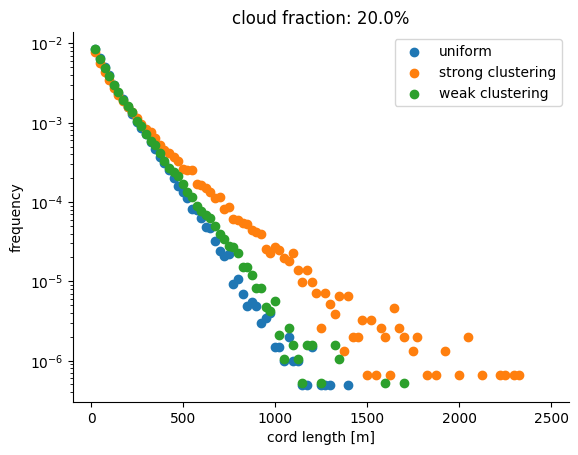

In [19]:
max_value = max(np.max(dic_experiments[key]["all"]) for key in dic_experiments.keys())
bins = np.arange(10, max_value, 25)

for i_d, key in enumerate(dic_experiments.keys()):

    data = dic_experiments[key]["all"]
    hist, edges = np.histogram(data, bins = bins, density = True)
    plt.scatter(edge_to_bin(edges), 
                hist, 
                color = dic_experiments[key]["colour"], 
                label = dic_experiments[key]["label"])

plt.gca().set_yscale('log')

plt.ylabel("frequency")
plt.xlabel("cord length [m]")

plt.title(f"cloud fraction: {cov_p*100}%")
plt.legend()

sn.despine()